In [1]:
import os
os.chdir("..")

In [2]:
import time
#basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import spacy 
#word modeling
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA 
from sklearn.decomposition import FactorAnalysis 
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from gensim.parsing.preprocessing import remove_stopwords
import nltk

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings('ignore',message="Precision")
from imblearn.over_sampling import SVMSMOTE, SMOTE, BorderlineSMOTE, RandomOverSampler, KMeansSMOTE, ADASYN

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from gensim.parsing.preprocessing import remove_stopwords

from nltk.corpus import stopwords


In [3]:
def heatconmat(y_true, y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(4,4))
    sns.heatmap(confusion_matrix(y_true,y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r')
    plt.show()
    print(classification_report(y_true,y_pred))

In [4]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


In [5]:
n_features = 2000
n_top_words = 20

# load data


In [12]:
train_docs = pd.read_csv('extracted/dataframes/steam_australia_norm.csv', 
                         names=["id", "funny", "helpful", "recommend",
                               "polarity", "positive", "subjectivity", "review"],
                        header=None).reset_index(drop=True)[1:]
recommend_indices = [i for i, x in enumerate(np.array(train_docs["recommend"])) if type(x) == str]
train_docs

,id,funny,helpful,recommend,polarity,positive,subjectivity,review
1,76561197970982479,NaN,No ratings yet,1,0.17444444444444446,True,0.3796031746031746,simple yet with great replayability in my opin...
2,76561197970982479,NaN,No ratings yet,1,0.3375,True,0.55,its unique and worth a playthrough
3,76561197970982479,NaN,No ratings yet,1,0.04999999999999999,False,0.4125,great atmosphere the gunplay can be a bit chun...
4,js41637,NaN,15 of 20 people (75%) found this review helpful,1,0.11458333333333336,True,0.6604166666666667,i know what you think when you see this title ...
5,js41637,NaN,0 of 1 people (0%) found this review helpful,1,-0.03611111111111112,False,0.3780045351473924,for a simple its actually not all that simple ...
...,...,...,...,...,...,...,...,...
59301,76561198312638244,NaN,No ratings yet,1,0.2333333333333333,True,0.13333333333333333,a must have classic from steam definitely wort...
59302,76561198312638244,NaN,No ratings yet,1,0.14250000000000004,True,0.4425,this game is a perfect remake of the original ...
59303,LydiaMorley,1 person found this review funny,1 of 2 people (50%) found this review helpful,1,0.08750000000000001,False,0.3833333333333333,had so much fun plaing this and collecting res...
59304,LydiaMorley,NaN,No ratings yet,1,1.0,True,1.0,d


## Removing stopwords

Stopwords have not been removed yet because they can be in a game's name. Those are defined now and should be Capitalized and with underscores (if it is the case), so their stopwords are safe

## Define valid / train

In [13]:
# train_docs["review"] = np.array([" ".join(replace_stopwords(str(w), stop_words)) for w in np.array(train_docs["review"])])
data_samples = np.array(train_docs['review'][recommend_indices])
true_y = np.array(np.array(train_docs["recommend"])[recommend_indices], dtype=int)


Verify that Team_Fortress_2 is in the vocabulary (verify the normalization did not make mistakes)

In [14]:
for i, text in enumerate(data_samples):
    text = str(text)
    
    if "Team_Fortress_2" in text:
        print(i, text)

270 this is an awesome game may overtake Team_Fortress_2 this game is an awesome shooter you play as different classes and like blacklight retribution you need to spend time farming coins to unlock characters for ever or you can wait for monthly trial rotations of the characters is great to play with friends and solo
573 Team_Fortress_2 is a cartoonlike first person shooter the diversity of classes is amazing while keeping no class overpoweredunderpowered best freetoplay game out there better for the p2ps 3
787 hello and welcome to the hatskin simulator if you played this game before july 2 2015 you may have been aware of the countless cosmetic items you could buy in Team_Fortress_2 to waste your time equipping and trading exactly 1248 cosmetics right now to be exact if you got sick and tired of all these cosmetics that partially kill the game well now there are skins thats right now these even more stuff to stop people from actually playing the gamebecause lets face it this game may b

In [9]:
#shuffled_indices = list(range(len(true_y)))
#np.random.shuffle(shuffled_indices)
#data_samples = data_samples[shuffled_indices]
#true_y = true_y[shuffled_indices]
def lda_cv(model, data_samples, true_y, n_features, tol=0.001, cv=3, verbose=0, nc=1, min_df=5, smote=False):
    t0 = time()
    models = []
    valid_acc = []
    valid_ys = []
    valid_arrr = []
    train_arrr = []
    train_acc = []

    for c in range(cv):
        if verbose > 0:
            print("CV: {}/{}".format(str(c+1), str(cv)))
        ind_from = int((len(data_samples) / cv) * c)
        ind_to = int((len(data_samples) / cv ) * (c+1))
        if c == cv-1:
            ind_to = -1
        if verbose > 2:
            print("Valid samples from", ind_from, "to", ind_to)
        valid_samples = data_samples[ind_from:ind_to]
        train_samples = np.concatenate((data_samples[:ind_from].astype("<U14000"), data_samples[ind_to:].astype("<U14000")))
        valid_y = true_y[ind_from:ind_to].astype(int)
        train_y = np.concatenate((true_y[:ind_from],true_y[ind_to:])).astype(int)
        print(valid_y.shape)
        print(train_y.shape)
        assert len(data_samples) == len(train_samples) + len(valid_samples)
        tfidf_vectorizer = CountVectorizer(max_df=0.95, min_df=min_df,
                                           max_features=n_features,
                                           stop_words='english')
        tfidf_vectorizer.fit(train_samples.astype('U'))
        train_data  = tfidf_vectorizer.transform(train_samples.astype('U')).toarray()
        valid_data  = tfidf_vectorizer.transform(valid_samples.astype('U')).toarray()
        if verbose > 2:
            print("Vectorizing done in %0.3fs." % (time() - t0))
        if smote:
            sm = SMOTE(random_state=42, n_jobs=-1)
            train_data, train_y = sm.fit_resample(train_data, train_y)


        flda = model(tol=0.001)
        t0 = time()
        flda.fit(train_data.astype(np.float32), train_y.astype(int))
        if verbose > 2:
            print("Linear Discriminant Analysis done in %0.3fs." % (time() - t0))

        predict_y_train = flda.predict(train_data)
        predict_y_valid = flda.predict(valid_data)
        train_arr = np.concatenate((predict_y_train.reshape([-1, 1]), train_y.reshape([-1, 1])), 1)
        valid_arr = np.concatenate((predict_y_valid.reshape([-1, 1]), valid_y.reshape([-1, 1])), 1)
        
        valid_ys += [valid_y]
        train_arrr += [train_arr]
        valid_arrr += [valid_arr]
        train_total = len(train_arr)
        valid_total = len(valid_arr)
        train_corrects = [i for i, x in enumerate(train_arr) if x[0] == x[1]]
        train_accuracy = len(train_corrects)/train_total
        valid_corrects = [i for i, x in enumerate(valid_arr) if x[0] == x[1]]
        valid_accuracy = len(valid_corrects)/valid_total
        if verbose > 1:
            print("Model Train accuracy:", len(train_corrects), "/", train_total, train_accuracy)
            print("Predict Train only Recommended accuracy:", np.sum(train_y), "/", total, np.sum(train_y)/train_total)
            print("Model Train accuracy:", len(train_corrects), "/", valid_total, valid_accuracy)
            print("Predict Predict only Recommended accuracy:", np.sum(valid_y), "/", valid_total, np.sum(valid_y)/valid_total)
        train_acc += [train_accuracy]
        valid_acc += [valid_accuracy]        
        models += [flda]
    return models, train_acc, valid_acc, train_arrr, valid_arrr

valid_arr_100_lda = np.concatenate(valid_arr_100_lda)

In [10]:
model = LinearDiscriminantAnalysis
models_100_lda, train_accuracies_100_lda, valid_accuracies_100_lda, \
    train_arr_100_lda, valid_arr_100_lda  = lda_cv(model, data_samples, true_y, 
                                                   n_features=100, cv=3, verbose=1)
models_500_lda, train_accuracies_500_lda, valid_accuracies_500_lda, \
    train_arr_500_lda, valid_arr_500_lda  = lda_cv(model, data_samples, true_y, 
                                                   n_features=500, cv=3, verbose=1)
models_1000_lda, train_accuracies_1000_lda, valid_accuracies_1000_lda, \
    train_arr_1000_lda, valid_arr_1000_lda  = lda_cv(model, data_samples, true_y, 
                                                   n_features=1000, cv=3, verbose=1)
models_2000_lda, train_accuracies_2000_lda, valid_accuracies_2000_lda, \
    train_arr_2000_lda, valid_arr_2000_lda  = lda_cv(model, data_samples, true_y, 
                                                   n_features=2000, cv=3, verbose=1)
#models_5000_lda, train_accuracies_5000_lda, valid_accuracies_5000_lda, \
#    train_arr_5000_lda, valid_arr_5000_lda  = lda_cv(model, data_samples, true_y, 
#                                                   n_features=5000, cv=3, verbose=1)
#models_10000_lda, train_accuracies_10000_lda, valid_accuracies_10000_lda, \
#    train_arr_10000_lda, valid_arr_10000_lda  = lda_cv(model, data_samples, true_y, 
#                                                   n_features=10000, cv=3, verbose=1)


CV: 1/3
(19768,)
(39537,)
CV: 2/3
(19768,)
(39537,)
CV: 3/3
(19768,)
(39537,)
CV: 1/3
(19768,)
(39537,)
CV: 2/3
(19768,)
(39537,)
CV: 3/3
(19768,)
(39537,)
CV: 1/3
(19768,)
(39537,)
CV: 2/3
(19768,)
(39537,)
CV: 3/3
(19768,)
(39537,)
CV: 1/3
(19768,)
(39537,)
CV: 2/3
(19768,)
(39537,)
CV: 3/3
(19768,)
(39537,)


In [11]:
zeros = np.zeros(len(train_accuracies_1000_lda), dtype=np.int)
ones = np.ones(len(train_accuracies_1000_lda), dtype=np.int)
zeros_ones = np.concatenate((zeros, ones), 0).reshape([-1, 1])
zeros_ones.shape
ones1 = np.ones(len(zeros_ones), dtype=np.int).reshape([-1, 1])

In [12]:
accuracies_100_lda = np.concatenate((np.array(train_accuracies_100_lda).reshape([-1, 1]), 
                                  np.array(valid_accuracies_100_lda).reshape([-1, 1])), 0)
accuracies_100_lda = np.concatenate((zeros_ones, ones1 * 100, accuracies_100_lda), 1)
accuracies_500_lda = np.concatenate((np.array(train_accuracies_500_lda).reshape([-1, 1]), 
                                  np.array(valid_accuracies_500_lda).reshape([-1, 1])), 0)
accuracies_500_lda = np.concatenate((zeros_ones, ones1 * 500, accuracies_500_lda), 1)
accuracies_1000_lda = np.concatenate((np.array(train_accuracies_1000_lda).reshape([-1, 1]), 
                                  np.array(valid_accuracies_1000_lda).reshape([-1, 1])), 0)
accuracies_1000_lda = np.concatenate((zeros_ones, ones1 * 1000, accuracies_1000_lda), 1)

accuracies_2000_lda = np.concatenate((np.array(train_accuracies_2000_lda).reshape([-1, 1]), 
                                  np.array(valid_accuracies_2000_lda).reshape([-1, 1])), 0)
accuracies_2000_lda = np.concatenate((zeros_ones, ones1 * 2000, accuracies_2000_lda), 1)

#accuracies_5000_lda = np.concatenate((np.array(train_accuracies_5000_lda).reshape([-1, 1]), 
#                                  np.array(valid_accuracies_5000_lda).reshape([-1, 1])), 0)
#accuracies_5000_lda = np.concatenate((zeros_ones, ones1 * 5000, accuracies_5000_lda), 1)

#accuracies_10000_lda = np.concatenate((np.array(train_accuracies_10000_lda).reshape([-1, 1]), 
#                                  np.array(valid_accuracies_10000_lda).reshape([-1, 1])), 0)
#accuracies_10000_lda = np.concatenate((zeros_ones, ones1 * 10000, accuracies_10000_lda), 1)


accuracies_lda = np.concatenate((accuracies_100_lda, 
                             accuracies_500_lda, 
                             accuracies_1000_lda, 
                             accuracies_2000_lda,
#                             accuracies_5000_lda,
#                             accuracies_10000_lda
                                ), 0)
accuracies_lda = pd.DataFrame(accuracies_lda, columns=["valid", "group", "acc"])

# Precision

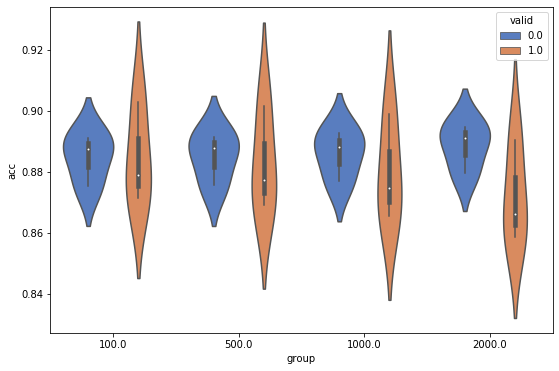

In [13]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=[9, 6])
g = sns.violinplot(x="group", y="acc", 
                   hue="valid", data=accuracies_lda, 
                   palette="muted")
plt.show()

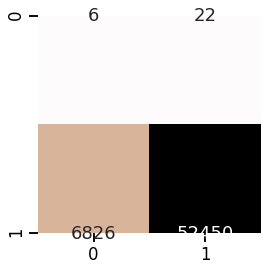

              precision    recall  f1-score   support

           0       0.00      0.21      0.00        28
           1       1.00      0.88      0.94     59276

    accuracy                           0.88     59304
   macro avg       0.50      0.55      0.47     59304
weighted avg       1.00      0.88      0.94     59304



In [14]:
valid_arr_100_lda = np.concatenate((valid_arr_100_lda))
heatconmat(valid_arr_100_lda[:,0], valid_arr_100_lda[:,1])

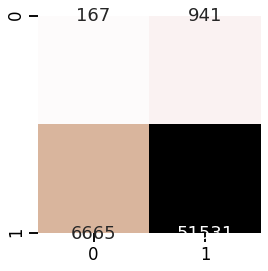

              precision    recall  f1-score   support

           0       0.02      0.15      0.04      1108
           1       0.98      0.89      0.93     58196

    accuracy                           0.87     59304
   macro avg       0.50      0.52      0.49     59304
weighted avg       0.96      0.87      0.91     59304



In [16]:
valid_arr_2000_lda = np.concatenate((valid_arr_2000_lda))
heatconmat(valid_arr_2000_lda[:,0], valid_arr_2000_lda[:,1])

In [ ]:
fig, ax = plt.subplots()
ax.bar([0,1], [len(df_y["true"]) - np.sum(df_y["true"]), np.sum(df_y["true"])])
ax.set_xticks([0, 1])
ax.set_xticklabels(["Not Recommended", "Recommended"])
ax.grid(False)

Predicting too many recommendations because of the bias in the data (Need to rectify)

In [ ]:
sns.set(style="whitegrid")
n_true_recommend = sum(df_y["true"])
n_true_preds = sum(df_y["predictions"])
n_false_recommend = len(df_y["true"]) - n_true_recommend
n_false_preds = len(df_y["predictions"]) - n_true_preds
x = np.array([0, 1])

width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [n_false_recommend, n_true_recommend], width, label='true')
rects2 = ax.bar(x + width/2, [n_false_preds, n_true_preds], width, label='predictions')
ax.set_xticks(x)
ax.set_xticklabels(["Not Recommended", "Recommended"])
ax.legend()
ax.grid(False)

In [18]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data_samples.astype('U'))
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=1,
                                max_features=n_features,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(data_samples.astype('U'))



In [22]:
all_data = tf.toarray()
flda = LinearDiscriminantAnalysis(n_components=1, tol=0.001)
flda.fit(all_data, true_y)
z = flda.transform(all_data)
predictions = flda.predict(all_data)
df_y = pd.DataFrame(np.concatenate((predictions.reshape(-1, 1), true_y.reshape(-1, 1), z.reshape(-1, 1)),1), columns=["predictions", "true", "z"])
df_y

,predictions,true,z
0,1.0,1.0,0.127522
1,1.0,1.0,0.897196
2,1.0,1.0,-0.036705
3,1.0,1.0,0.542101
4,1.0,1.0,-0.589782
...,...,...,...
59300,1.0,1.0,-0.018208
59301,1.0,1.0,0.318958
59302,1.0,1.0,-1.748863
59303,1.0,1.0,0.055282


In [23]:
tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names()).reshape([-1, 1])
coefs = flda.coef_.reshape([-1, 1])
coefs = pd.DataFrame(np.concatenate((coefs, tfidf_feature_names), 1), columns=["coef", "feature_name"])
coefs

,coef,feature_name
0,-0.004729242348332834,1080
1,-0.8164766768122469,14
2,0.04579993559259252,16
3,0.2575771892467669,1st
4,0.11433999132048359,2d
...,...,...
1995,-0.2900740749789162,your_own
1996,0.09049821921519392,youre
1997,0.10209121011894237,youve
1998,0.10217179536150414,zombie


Recommendation distribution

In [26]:
coefs["coef"] = np.array(coefs["coef"], dtype=np.float32)
coefs = coefs.sort_values(by=['coef'])
coefs[:50]

,coef,feature_name
726,-1.684551,gammers
1334,-1.019055,plan
77,-1.002141,animals
1360,-0.986520,polished
293,-0.945805,chu
708,-0.930012,frustrating
1556,-0.907278,seeing
1883,-0.901851,value
44,-0.893645,admit
1277,-0.875959,overpriced


In [ ]:
coefs = coefs.sort_values(by=['coef'], ascending=False)
coefs[:20]

In [83]:
means = flda.means_
means_df = pd.DataFrame(np.concatenate((means.reshape([1000, -1]), tfidf_feature_names), 1),
                        columns=["bad_reference", "good_reference", "feature_name"])

means_df["bad_reference"] = np.array(means_df["bad_reference"], dtype=np.float32)
means_df = means_df.sort_values(by=['bad_reference'], ascending=False)
means_df[:n_top_words]

,bad_reference,good_reference,feature_name
687,0.046736,0.010275304623105863,problems
187,0.041719,0.010262751546499378,crash
0,0.034268,0.0008233198584713345,1080
500,0.033768,0.0014022020304012652,le
532,0.024715,0.0050441333591735495,loot
32,0.022258,0.004364111696715747,ai
769,0.018860,0.002633127239622992,series
520,0.018267,0.0010749576591177065,literally
675,0.017555,0.0017350457484507315,possible
269,0.017543,0.00275867489554648,engine


In [84]:
means_df["good_reference"] = np.array(means_df["good_reference"], dtype=np.float32)
means_df = means_df.sort_values(by=['good_reference'], ascending=False)
means_df[:n_top_words]

,bad_reference,good_reference,feature_name
673,0.001262,0.108178,port
173,0.000946,0.104513,continue
671,0.000936,0.039039,poor
689,0.007669,0.033976,pros
171,0.000594,0.032430,constantly
189,0.007232,0.031064,crazy
829,0.001157,0.030087,starting
541,0.001164,0.029581,mac
329,0.001318,0.029082,food
256,0.000560,0.028327,ego


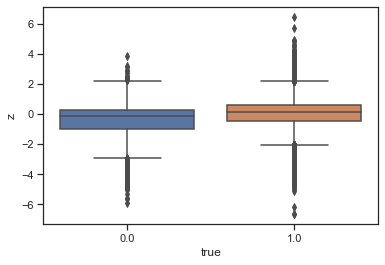

In [85]:
sns.set(style="ticks", color_codes=True)
sns.boxplot(x="true", y="z", data=df_y);

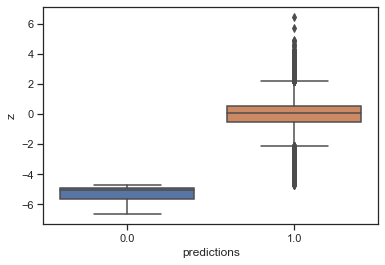

In [86]:
sns.set(style="ticks", color_codes=True)
sns.boxplot(x="predictions", y="z", data=df_y);

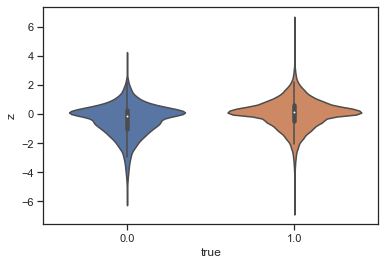

In [87]:
sns.set(style="ticks", color_codes=True)
sns.violinplot(x="true", y="z", data=df_y);

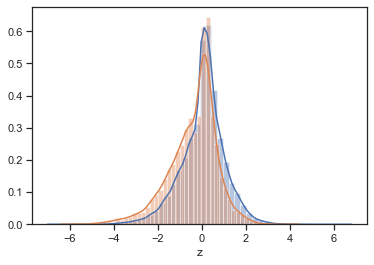

In [88]:
sns.set(style="ticks", color_codes=True)
sns.distplot(df_y["z"][df_y["true"] == 1], hist=True, label="Recommended")
sns.distplot(df_y["z"][df_y["true"] == 0], hist=True, label="Not Recommended")

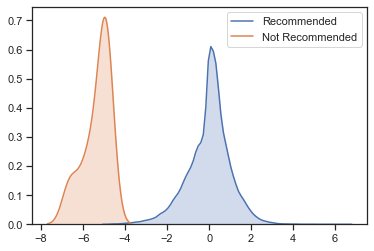

In [89]:
sns.set(style="ticks", color_codes=True)
sns.kdeplot(df_y["z"][df_y["predictions"] == 1], shade=True, label="Recommended")
sns.kdeplot(df_y["z"][df_y["predictions"] == 0], shade=True, label="Not Recommended")

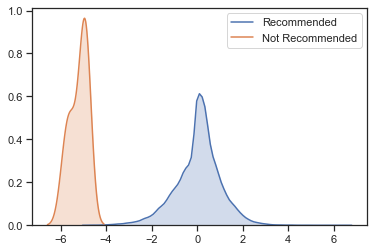

In [90]:
y = np.array(df_y["predictions"])
arr = np.concatenate((y.reshape([-1, 1]), true_y.reshape([-1, 1])), 1)
corrects = [i for i, x in enumerate(arr) if x[0] == x[1]]
corrects_pos = [i for i, x in enumerate(arr) if x[0] == x[1] and x[0] == 1]
corrects_neg = [i for i, x in enumerate(arr) if x[0] == x[1] and x[0] == 0]
sns.set(style="ticks", color_codes=True)
sns.kdeplot(df_y["z"][corrects_pos], shade=True, label="Recommended")
sns.kdeplot(df_y["z"][corrects_neg], shade=True, label="Not Recommended")

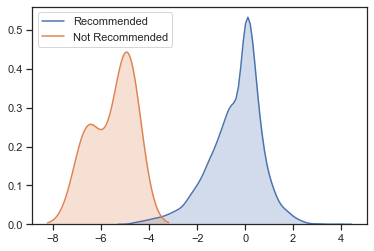

In [91]:
incorrects = [i for i, x in enumerate(arr) if x[0] == x[1]]
incorrects_pos = [i for i, x in enumerate(arr) if x[0] != x[1] and x[0] == 1]
incorrects_neg = [i for i, x in enumerate(arr) if x[0] != x[1] and x[0] == 0]
sns.set(style="ticks", color_codes=True)
sns.kdeplot(df_y["z"][incorrects_pos], shade=True, label="Recommended")
sns.kdeplot(df_y["z"][incorrects_neg], shade=True, label="Not Recommended")

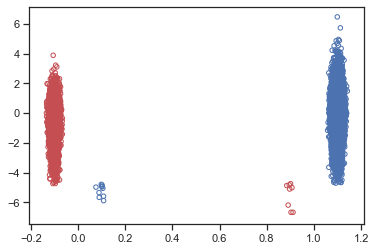

In [92]:
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

df_y["true"] = np.array([float(x) for x in df_y["true"]])
df_y["true"] = rand_jitter(np.array(df_y["true"]))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(df_y["true"][corrects_pos]+0.1, df_y["z"][corrects_pos], marker="o", s=20, facecolors='none', edgecolors='b')
ax.scatter(df_y["true"][corrects_neg]+0.1, df_y["z"][corrects_neg], marker="o", s=20, facecolors='none', edgecolors='b')
ax.scatter(df_y["true"][incorrects_pos]-0.1, df_y["z"][incorrects_pos], marker="o", s=20, facecolors='none', edgecolors='r')
ax.scatter(df_y["true"][incorrects_neg]-0.1, df_y["z"][incorrects_neg], marker="o", s=20, facecolors='none', edgecolors='r')


In [ ]:
import seaborn as sns
df_y = pd.DataFrame(np.concatenate((arr, z.reshape(-1, 1)),1), columns=["predictions", "true", "z"])
sns.set(style="whitegrid")
g = sns.catplot(x="true", y="z", hue="predictions", data=df_y,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("z")

In [ ]:
import seaborn as sns
df_y = pd.DataFrame(np.concatenate((arr, z.reshape(-1, 1)),1), columns=["predictions", "true", "z"])
# sns.set(style="whitegrid")
g = sns.boxplot(x="true", y="z", hue="predictions", data=df_y, palette="muted")

In [ ]:
g = sns.violinplot(x="true", y="z", hue="predictions", data=df_y, palette="muted")

In [ ]:
import seaborn as sns
arr = np.concatenate((y.reshape([-1, 1]), true_y.reshape([-1, 1])), 1)
corrects = np.array([0 if x[0] == x[1] else 1 for i, x in enumerate(arr)])
recommends = np.array([0 if x[0] == 0 else 1 for i, x in enumerate(arr)])

df_y2 = pd.DataFrame(np.concatenate((corrects.reshape(-1, 1), 
                                    recommends.reshape(-1, 1), 
                                    z.reshape(-1, 1)),1), 
                    columns=["correct", "recommend", "z"])

sns.set(style="whitegrid")
g = sns.catplot(x="correct", y="z", hue="recommend", data=df_y2,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("z")

In [ ]:
g = sns.violinplot(x="correct", y="z", hue="recommend", data=df_y2, palette="muted")

In [ ]:
g = sns.boxplot(x="correct", y="z", hue="recommend", data=df_y2, palette="muted")

# SMOTE

In [ ]:
model = LinearDiscriminantAnalysis
models_100_lda, train_accuracies_100_lda, valid_accuracies_100_lda, \
    train_arr_100_lda, valid_arr_100_lda  = lda_cv(model, data_samples, true_y, 
                                                   n_features=100, cv=3, verbose=1, smote=True)
models_500_lda, train_accuracies_500_lda, valid_accuracies_500_lda, \
    train_arr_500_lda, valid_arr_500_lda  = lda_cv(model, data_samples, true_y, 
                                                   n_features=500, cv=3, verbose=1, smote=True)
models_1000_lda, train_accuracies_1000_lda, valid_accuracies_1000_lda, \
    train_arr_1000_lda, valid_arr_1000_lda  = lda_cv(model, data_samples, true_y, 
                                                   n_features=1000, cv=3, verbose=1, smote=True)
models_2000_lda, train_accuracies_2000_lda, valid_accuracies_2000_lda, \
    train_arr_2000_lda, valid_arr_2000_lda  = lda_cv(model, data_samples, true_y, 
                                                   n_features=2000, cv=3, verbose=1, smote=True)
models_5000_lda, train_accuracies_5000_lda, valid_accuracies_5000_lda, \
    train_arr_5000_lda, valid_arr_5000_lda  = lda_cv(model, data_samples, true_y, 
                                                   n_features=5000, cv=3, verbose=1, smote=True)
models_10000_lda, train_accuracies_10000_lda, valid_accuracies_10000_lda, \
    train_arr_10000_lda, valid_arr_10000_lda  = lda_cv(model, data_samples, true_y, 
                                                   n_features=10000, cv=3, verbose=1, smote=True)


In [ ]:
zeros = np.zeros(len(train_accuracies_1000_lda), dtype=np.int)
ones = np.ones(len(train_accuracies_1000_lda), dtype=np.int)
zeros_ones = np.concatenate((zeros, ones), 0).reshape([-1, 1])
zeros_ones.shape
ones1 = np.ones(len(zeros_ones), dtype=np.int).reshape([-1, 1])

In [ ]:
accuracies_100_lda = np.concatenate((np.array(train_accuracies_100_lda).reshape([-1, 1]), 
                                  np.array(valid_accuracies_100_lda).reshape([-1, 1])), 0)
accuracies_100_lda = np.concatenate((zeros_ones, ones1 * 100, accuracies_100_lda), 1)
accuracies_500_lda = np.concatenate((np.array(train_accuracies_500_lda).reshape([-1, 1]), 
                                  np.array(valid_accuracies_500_lda).reshape([-1, 1])), 0)
accuracies_500_lda = np.concatenate((zeros_ones, ones1 * 500, accuracies_500_lda), 1)
accuracies_1000_lda = np.concatenate((np.array(train_accuracies_1000_lda).reshape([-1, 1]), 
                                  np.array(valid_accuracies_1000_lda).reshape([-1, 1])), 0)
accuracies_1000_lda = np.concatenate((zeros_ones, ones1 * 1000, accuracies_1000_lda), 1)

accuracies_2000_lda = np.concatenate((np.array(train_accuracies_2000_lda).reshape([-1, 1]), 
                                  np.array(valid_accuracies_2000_lda).reshape([-1, 1])), 0)
accuracies_2000_lda = np.concatenate((zeros_ones, ones1 * 2000, accuracies_2000_lda), 1)

accuracies_5000_lda = np.concatenate((np.array(train_accuracies_5000_lda).reshape([-1, 1]), 
                                  np.array(valid_accuracies_5000_lda).reshape([-1, 1])), 0)
accuracies_5000_lda = np.concatenate((zeros_ones, ones1 * 5000, accuracies_5000_lda), 1)

accuracies_10000_lda = np.concatenate((np.array(train_accuracies_10000_lda).reshape([-1, 1]), 
                                  np.array(valid_accuracies_10000_lda).reshape([-1, 1])), 0)
accuracies_10000_lda = np.concatenate((zeros_ones, ones1 * 10000, accuracies_10000_lda), 1)


accuracies_lda = np.concatenate((accuracies_100_lda, 
                             accuracies_500_lda, 
                             accuracies_1000_lda, 
                             accuracies_2000_lda,
                             accuracies_5000_lda,
                             accuracies_10000_lda
                                ), 0)
accuracies_lda = pd.DataFrame(accuracies_lda, columns=["valid", "group", "acc"])

In [ ]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=[9, 6])
g = sns.violinplot(x="group", y="acc", 
                   hue="valid", data=accuracies_lda, 
                   palette="muted")
plt.show()

In [ ]:
valid_arr_2000_lda = np.concatenate((valid_arr_2000_lda))
heatconmat(valid_arr_2000_lda[:,0], valid_arr_2000_lda[:,1])

In [33]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=3,
                                   max_features=2000,
                                   stop_words='english')
tfidf_vectorizer.fit(data_samples.astype('U'))
all_data  = tfidf_vectorizer.transform(data_samples.astype('U')).toarray()

In [34]:
sm = SMOTE(random_state=42, n_jobs=-1)
X_res, Y_res  = sm.fit_resample(all_data , true_y)

In [35]:
flda_smote = LinearDiscriminantAnalysis(n_components=1, tol=0.001)
t0 = time()
z = flda_smote.fit_transform(X_res, Y_res)
print("done in %0.3fs." % (time() - t0))


done in 102.017s.


In [36]:
z = flda_smote.transform(all_data)
predict_y = flda_smote.predict(all_data)
arr = np.concatenate((predict_y.reshape([-1, 1]), true_y.reshape([-1, 1])), 1)
total = len(arr)
corrects = [i for i, x in enumerate(arr) if x[0] == x[1]]
print(len(corrects), "/", total, len(corrects)/total)
df_y = pd.DataFrame(np.concatenate((predict_y.reshape(-1, 1), true_y.reshape(-1, 1), z.reshape(-1, 1)),1), columns=["predictions", "true", "z"])
df_y

38084 / 59305 0.6421718236236404


,predictions,true,z
0,0.0,1.0,-1.455094
1,1.0,1.0,1.161828
2,1.0,1.0,0.541549
3,1.0,1.0,1.578034
4,1.0,1.0,0.583867
...,...,...,...
59300,1.0,1.0,0.443453
59301,1.0,1.0,0.986456
59302,1.0,1.0,1.004097
59303,0.0,1.0,-0.314018


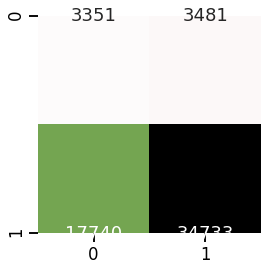

              precision    recall  f1-score   support

         0.0       0.16      0.49      0.24      6832
         1.0       0.91      0.66      0.77     52473

    accuracy                           0.64     59305
   macro avg       0.53      0.58      0.50     59305
weighted avg       0.82      0.64      0.71     59305



In [37]:
true_y2 = np.array(df_y["true"])
heatconmat(true_y2, predict_y)

In [38]:
tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names()).reshape([-1, 1])
coefs = flda_smote.coef_.reshape([-1, 1])
coefs = pd.DataFrame(np.concatenate((coefs, tfidf_feature_names), 1), columns=["coef", "feature_name"])

In [39]:
coefs["coef"] = np.array(coefs["coef"], dtype=np.float32)
coefs = coefs.sort_values(by=['coef'])
coefs[:20]

,coef,feature_name
438,-5.822858,depending
499,-5.748482,dr
1101,-5.558056,meant
1769,-4.745362,thrown
1541,-4.523391,selection
1858,-4.172522,useless
1220,-4.107311,objectives
62,-4.096398,admit
542,-3.771373,encounter
325,-3.668853,common


In [40]:
coefs = coefs.sort_values(by=['coef'], ascending=False)
coefs[:20]

,coef,feature_name
1068,4.517825,madden
1555,4.239031,sets
1282,4.109461,pena
1906,3.804686,warning
1386,3.799052,pve
1567,3.778383,shit
164,3.736764,bar
254,3.682943,cake
1031,3.620600,loadout
916,3.544762,isaac


In [41]:
means = flda_smote.means_
means_df = pd.DataFrame(np.concatenate((means.reshape([2000, -1]), tfidf_feature_names), 1),
                        columns=["bad_reference", "good_reference", "feature_name"])

means_df["bad_reference"] = np.array(means_df["bad_reference"], dtype=np.float32)
means_df = means_df.sort_values(by=['bad_reference'], ascending=False)
means_df[:n_top_words]

,bad_reference,good_reference,feature_name
1352,0.096293,0.000311595625403607,prefer
352,0.071231,0.0001831206531833108,continue
1001,0.050212,0.0031311378521512853,legends
1,0.042321,0.0015383820239764834,000
1381,0.030980,0.0015126827368345092,push
381,0.021749,0.0009039827751918748,crashing
1527,0.017088,0.002374439017875151,score
1043,0.016077,0.0007137150496456635,looks
1355,0.015246,0.0015116541778887505,present
527,0.012797,0.0014100923043544116,edition


In [42]:
means_df["good_reference"] = np.array(means_df["good_reference"], dtype=np.float32)
means_df = means_df.sort_values(by=['good_reference'], ascending=False)
means_df[:n_top_words]

,bad_reference,good_reference,feature_name
1373,0.001347,0.042569,ps
1349,0.000808,0.035495,powers
373,0.001047,0.032299,craft
1656,0.000821,0.026701,stand
1092,0.001100,0.026694,matchmaking
1505,0.000816,0.023589,russian
92,0.000748,0.022081,angry
349,0.000284,0.022039,constant
1073,0.001897,0.020276,major
656,0.000618,0.018491,finding


In [43]:
z = flda_smote.transform(X_res)
predict_y = flda_smote.predict(X_res)
arr = np.concatenate((predict_y.reshape([-1, 1]), Y_res.reshape([-1, 1])), 1)
total = len(arr)
corrects = [i for i, x in enumerate(arr) if x[0] == x[1]]
print(len(corrects), "/", total, len(corrects)/total)
df_y = pd.DataFrame(np.concatenate((arr, z.reshape(-1, 1)),1), columns=["predictions", "true", "z"])
df_y

71700 / 104946 0.6832085072322909


,predictions,true,z
0,0.0,1.0,-1.455094
1,1.0,1.0,1.161828
2,1.0,1.0,0.541549
3,1.0,1.0,1.578034
4,1.0,1.0,0.583867
...,...,...,...
104941,0.0,0.0,-0.477304
104942,0.0,0.0,-0.084325
104943,1.0,0.0,2.070866
104944,1.0,0.0,0.785937


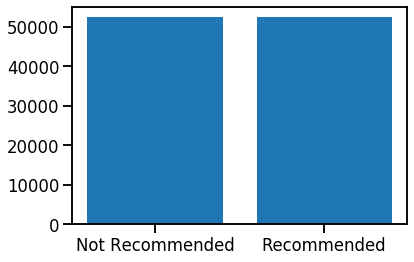

In [44]:
fig, ax = plt.subplots()
ax.bar([0,1], [len(df_y["true"]) - np.sum(df_y["true"]), np.sum(df_y["true"])])
ax.set_xticks([0, 1])
ax.set_xticklabels(["Not Recommended", "Recommended"])
ax.grid(False)

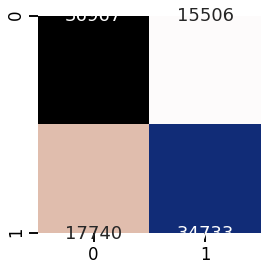

              precision    recall  f1-score   support

         0.0       0.68      0.70      0.69     52473
         1.0       0.69      0.66      0.68     52473

    accuracy                           0.68    104946
   macro avg       0.68      0.68      0.68    104946
weighted avg       0.68      0.68      0.68    104946



In [45]:
true_y2 = np.array(df_y["true"])
heatconmat(true_y2, predict_y)

In [46]:
tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names()).reshape([-1, 1])
coefs = flda_smote.coef_.reshape([-1, 1])
coefs = pd.DataFrame(np.concatenate((coefs, tfidf_feature_names), 1), columns=["coef", "feature_name"])

In [47]:
coefs["coef"] = np.array(coefs["coef"], dtype=np.float32)
coefs = coefs.sort_values(by=['coef'])
coefs[:20]

,coef,feature_name
438,-5.822858,depending
499,-5.748482,dr
1101,-5.558056,meant
1769,-4.745362,thrown
1541,-4.523391,selection
1858,-4.172522,useless
1220,-4.107311,objectives
62,-4.096398,admit
542,-3.771373,encounter
325,-3.668853,common


In [48]:
coefs = coefs.sort_values(by=['coef'], ascending=False)
coefs[:20]

,coef,feature_name
1068,4.517825,madden
1555,4.239031,sets
1282,4.109461,pena
1906,3.804686,warning
1386,3.799052,pve
1567,3.778383,shit
164,3.736764,bar
254,3.682943,cake
1031,3.620600,loadout
916,3.544762,isaac


In [49]:
means = flda_smote.means_
means_df = pd.DataFrame(np.concatenate((means.reshape([n_features, -1]), tfidf_feature_names), 1),
                        columns=["bad_reference", "good_reference", "feature_name"])

means_df["bad_reference"] = np.array(means_df["bad_reference"], dtype=np.float32)
means_df = means_df.sort_values(by=['bad_reference'], ascending=False)
means_df[:n_top_words]

,bad_reference,good_reference,feature_name
1352,0.096293,0.000311595625403607,prefer
352,0.071231,0.0001831206531833108,continue
1001,0.050212,0.0031311378521512853,legends
1,0.042321,0.0015383820239764834,000
1381,0.030980,0.0015126827368345092,push
381,0.021749,0.0009039827751918748,crashing
1527,0.017088,0.002374439017875151,score
1043,0.016077,0.0007137150496456635,looks
1355,0.015246,0.0015116541778887505,present
527,0.012797,0.0014100923043544116,edition


In [ ]:
means_df["good_reference"] = np.array(means_df["good_reference"], dtype=np.float32)
means_df = means_df.sort_values(by=['good_reference'], ascending=False)
means_df[:n_top_words]